## Практическое задание к уроку 13 по теме "Модели BERT и GPT".

*Взять датасет https://huggingface.co/datasets/merionum/ru_paraphraser и решить задачу парафраза*

Загрузим библиотеки и датасеты:

In [1]:
%matplotlib inline

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
from torch import nn
from torchinfo import summary
from transformers import AutoTokenizer, AutoModel
from transformers.utils import logging
logging.set_verbosity_error()

In [2]:
RANDOM_STATE = 29

In [3]:
train_dataset = load_dataset('merionum/ru_paraphraser', data_files='train.jsonl')
test_dataset = load_dataset('merionum/ru_paraphraser', data_files='test.jsonl')

Using custom data configuration merionum--ru_paraphraser-dd0dcf23f5ec66a4
Found cached dataset json (/home/shkin/.cache/huggingface/datasets/merionum___json/merionum--ru_paraphraser-dd0dcf23f5ec66a4/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration merionum--ru_paraphraser-62b622e3b2274f4e
Found cached dataset json (/home/shkin/.cache/huggingface/datasets/merionum___json/merionum--ru_paraphraser-62b622e3b2274f4e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
pd.DataFrame(train_dataset['train']).head()

,id,id_1,id_2,text_1,text_2,class
0,1,201,8159,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,0
1,2,202,8158,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,0
2,3,273,8167,Президент Египта ввел чрезвычайное положение в...,Власти Египта угрожают ввести в стране чрезвыч...,0
3,4,220,8160,Вернувшихся из Сирии россиян волнует вопрос тр...,Самолеты МЧС вывезут россиян из разрушенной Си...,-1
4,5,223,8160,В Москву из Сирии вернулись 2 самолета МЧС с р...,Самолеты МЧС вывезут россиян из разрушенной Си...,0


In [5]:
train_dataset.shape, test_dataset.shape

({'train': (7227, 6)}, {'train': (1924, 6)})

Датасеты содержат следующие классы:

1: precise paraphrases  
0: near paraphrases  
-1: non-paraphrases

Посмотрим на их распределение:

In [6]:
pd.Series(train_dataset['train']['class']).value_counts()

0     2957
-1    2582
1     1688
dtype: int64

In [7]:
pd.Series(test_dataset['train']['class']).value_counts()

0     778
-1    772
1     374
dtype: int64

In [8]:
for i in range(10):
    print(train_dataset['train']['text_1'][i] + ' ||| ' + train_dataset['train']['text_2'][i])
    print(train_dataset['train']['class'][i], end='\n\n')

Полицейским разрешат стрелять на поражение по гражданам с травматикой. ||| Полиции могут разрешить стрелять по хулиганам с травматикой.
0

Право полицейских на проникновение в жилище решили ограничить. ||| Правила внесудебного проникновения полицейских в жилище уточнят.
0

Президент Египта ввел чрезвычайное положение в мятежных городах. ||| Власти Египта угрожают ввести в стране чрезвычайное положение.
0

Вернувшихся из Сирии россиян волнует вопрос трудоустройства на родине. ||| Самолеты МЧС вывезут россиян из разрушенной Сирии.
-1

В Москву из Сирии вернулись 2 самолета МЧС с россиянами на борту. ||| Самолеты МЧС вывезут россиян из разрушенной Сирии.
0

Приставы соберут отпечатки пальцев российских должников. ||| Приставы снимут отпечатки пальцев у злостных неплательщиков.
1

На саратовского дебошира с борта самолета Москва - Хургада заведено дело. ||| Саратовский дебошир отказывается возвращаться домой из Египта.
-1

ЦИК хочет отказаться от электронной системы подсчета голосов. ||| Ц

В основе модели будет лежать ruBERT - мультиязычная модель BERT, дообученная командой DeepPavlov на русских текстах википедии и новостей. Возьмём её токенайзер, токенизируем тексты и посмотрим на их длину в токенах:

In [9]:
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

In [10]:
pairs_train = list(zip(train_dataset['train']['text_1'], train_dataset['train']['text_2']))
pairs_test = list(zip(test_dataset['train']['text_1'], test_dataset['train']['text_2']))

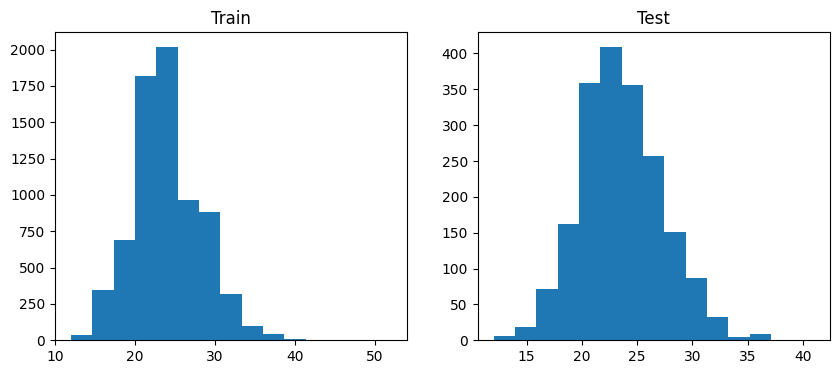

In [11]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist([len(tokenizer.encode(pair)) for pair in pairs_train], bins=15)
plt.title('Train')

plt.subplot(1, 2, 2)
plt.hist([len(tokenizer.encode(pair)) for pair in pairs_test], bins=15)
plt.title('Test')

plt.show()

Исходя из гистограмм, выберем фиксированную длину текстов:

In [12]:
MAX_LEN = 40

Напишем класс датасета:

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
class ParaphraseDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        
        # Объединяем два текста в кортеж
        pairs = list(zip(self.data['train']['text_1'], self.data['train']['text_2']))
        
        # Токенизируем кортеж
        self.inputs = tokenizer(pairs, padding=True, truncation=True, max_length=MAX_LEN, return_tensors='pt')
        
        # Запишем таргет. Добавляем 1 к значениям классов, т.к. CrossEntropyLoss не работает с 
        # отрицательными значениями таргета
        self.targets = torch.from_numpy(np.array(self.data['train']['class'], dtype=int) + 1)
    
    # Для правильного извлечения нужных данных по индексу напишем функцию, так как
    # токенайзер возвращает словарь
    def get_example(self, index):
        return {k: v[index].to(device) for k, v in self.inputs.items()}
    
    def __getitem__(self, index):
        return self.get_example(index), self.targets[index]
    
    def __len__(self):
        return len(self.data['train'])

Создадим даталоадеры:

In [15]:
BATCH_SIZE = 64

In [16]:
torch.random.manual_seed(RANDOM_STATE)

data_train = ParaphraseDataset(train_dataset)
data_test = ParaphraseDataset(test_dataset)

train_loader = torch.utils.data.DataLoader(data_train,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(data_test,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

Напишем сеть. На выходе берта добавляем несколько полносвязных слоёв для классификации. Дропауты закомментированы, т.к. их использование привело к падению точности на тесте. Пулинг выходов берта осуществлялся двумя способами: сначала по инструкции из описания sentence similarity моделей на *https://huggingface.co*, то есть выход паддинговых токенов занулялся и делался mean-pooling. Потом попробовал сделать cls-pooling, где берётся эмбеддинг cls-токена. В итоге cls-pooling оказался чуть лучше. В коде оставлена возможность выбора типа пулинга.

In [17]:
class Net(nn.Module):
    def __init__(self, mean_pooling=True):
        super().__init__()
        self.mean_pooling = mean_pooling
        self.bert = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased')
        self.classifier = nn.Sequential(nn.Linear(768, 256),
                                        nn.ReLU(),
                                        # nn.Dropout(0.25),
                                        nn.Linear(256, 64),
                                        nn.ReLU(),
                                        # nn.Dropout(0.25),
                                        nn.Linear(64, 3))
    
    def forward(self, x):
        
        output = self.bert(**x)
        
        if self.mean_pooling:
            token_embeddings = output[0]
            expanded_mask = x['attention_mask'].unsqueeze(-1).expand(token_embeddings.size()).float()
            
        # В инструкции в знаменателе дроби использована функция torch.clamp() для исключения 
        # возможности деления на ноль. Но это возможно только если весь текст состоит из  
        # паддинга, то есть в нашем случае невозможно. Убрано, чтобы показать, что инструкция  
        # была проработана, а не просто скопирована
            x = torch.sum(token_embeddings * expanded_mask, dim=1) / expanded_mask.sum(dim=1)
        else:
        # cls-pooling:
            x = output[0][:, 0]
            
        x = self.classifier(x)
        return x

Посмотрим на количество параметров:

In [18]:
summary(Net())

Layer (type:depth-idx)                                  Param #
Net                                                     --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              91,812,096
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Sequential: 1-2                                       --
│    └─Linear: 2-4                                      196,864
│    └─ReLU: 2

Напишем функцию для обучения. Обучать будем весь берт, кроме пулера - так как это показало лучший результат - а также наш классификатор. Возьмём разные значения скорости обучения для берта и классификатора, так как берт уже был обучен, и требуется небольшая корректировка его весов, а классификатор обучается с нуля. В целом, код обучения стандартный.

In [19]:
def train_nn(epochs=5, bert_lr=1e-6, dense_lr=1e-5, mean_pooling=True, return_model=False):
    
    torch.random.manual_seed(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True
    torch.cuda.empty_cache()
    
    net = Net(mean_pooling=mean_pooling).to(device)
    
    for param in net.bert.pooler.parameters():
        param.requires_grad = False
    
    param_groups = [
                    # {'params': net.bert.parameters(), 'lr': bert_lr},
                    {'params': net.bert.embeddings.parameters(), 'lr': bert_lr},
                    {'params': net.bert.encoder.parameters(), 'lr': bert_lr},
                    {'params': net.classifier.parameters(), 'lr': dense_lr}
                   ]
    optimizer = torch.optim.Adam(param_groups)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_losses = 0.
        test_losses = 0.
        train_metrics = 0.
        test_metrics = 0.

        for inputs, labels in train_loader:
            net.train()
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses += loss.item()

            net.eval()
            outputs = net(inputs)
            
            train_metrics += accuracy_score(labels.cpu(), torch.argmax(outputs, dim=-1).cpu())

        print(f'Epoch [{epoch + 1}/{epochs}]. ' \
              f'Train Loss: {train_losses / len(train_loader):.3f}. ' \
              f'Train Accuracy: {train_metrics / len(train_loader):.3f}', end='. ')

        with torch.inference_mode():
            for inputs, labels in test_loader:

                labels = labels.to(device)
                outputs = net(inputs)

                loss = criterion(outputs, labels)
                test_losses += loss.item()
                
                test_metrics += accuracy_score(labels.cpu(), torch.argmax(outputs, dim=-1).cpu())

        print(f'Test Loss: {test_losses / len(test_loader):.3f}. Test Accuracy: {test_metrics / len(test_loader):.3f}')

    print('Training is finished!')
    if return_model:
        return net

In [20]:
train_nn(epochs=20, bert_lr=8e-7, dense_lr=1e-5, mean_pooling=False)

Epoch [1/20]. Train Loss: 1.040. Train Accuracy: 0.545. Test Loss: 0.987. Test Accuracy: 0.603
Epoch [2/20]. Train Loss: 0.939. Train Accuracy: 0.620. Test Loss: 0.882. Test Accuracy: 0.634
Epoch [3/20]. Train Loss: 0.827. Train Accuracy: 0.644. Test Loss: 0.783. Test Accuracy: 0.647
Epoch [4/20]. Train Loss: 0.733. Train Accuracy: 0.658. Test Loss: 0.738. Test Accuracy: 0.654
Epoch [5/20]. Train Loss: 0.682. Train Accuracy: 0.689. Test Loss: 0.731. Test Accuracy: 0.688
Epoch [6/20]. Train Loss: 0.652. Train Accuracy: 0.727. Test Loss: 0.719. Test Accuracy: 0.702
Epoch [7/20]. Train Loss: 0.620. Train Accuracy: 0.739. Test Loss: 0.710. Test Accuracy: 0.702
Epoch [8/20]. Train Loss: 0.600. Train Accuracy: 0.751. Test Loss: 0.713. Test Accuracy: 0.696
Epoch [9/20]. Train Loss: 0.586. Train Accuracy: 0.759. Test Loss: 0.716. Test Accuracy: 0.689
Epoch [10/20]. Train Loss: 0.565. Train Accuracy: 0.769. Test Loss: 0.713. Test Accuracy: 0.700
Epoch [11/20]. Train Loss: 0.550. Train Accuracy:

Результат не получился впечатляющим: всего 70%. Возможно, что дело в маленьком размере датасета и в человеческом факторе при разметке текстов.